# Code to plot the prediction ranks evolving over time


In [4]:
import pandas as pd 

import matplotlib.pyplot as plt

from common import set_theme

FONTSIZE = 20
# set_theme(fontsize=FONTSIZE)

plt.rcParams["font.size"] = FONTSIZE
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.grid"] = True
# only Horizontal grid
plt.rcParams["axes.grid.axis"] = "y"


# Legend font size

plt.rcParams["legend.fontsize"] = FONTSIZE + 5
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example: Preferential Attachment on the Enron Dataset


First, we load the predictiong score obtained.

For each event in the dataset, this one contains 

In [33]:
from common import train_val_test_split_dataframe

# score_path = "output/one_vs_few/uci_tgn_scores_one_vs_few.csv"

dataset_name = "wikipedia"
method = "preferential_attachment"


score_path = f"output/{method}_{dataset_name}_scores.csv"

scores_df = pd.read_csv(score_path, index_col=0)

scores_df.head()

,score_pos,src,dst,t,score_historical_edge,score_inductive_edge,score_overlap_edge,score_historical_dst,score_inductive_dst,score_overlap_dst,split
0,0.0,1,8228,0,0.0,0.0,0.0,0.0,0.0,0.0,train
1,0.0,2,8229,36,0.0,0.0,0.0,0.0,0.0,0.0,train
2,0.0,2,8229,77,0.0,0.0,0.0,0.0,0.0,0.0,train
3,0.0,3,8230,131,0.0,0.0,0.0,0.0,0.0,0.0,train
4,0.0,2,8229,150,0.0,0.0,0.0,0.0,0.0,0.0,train


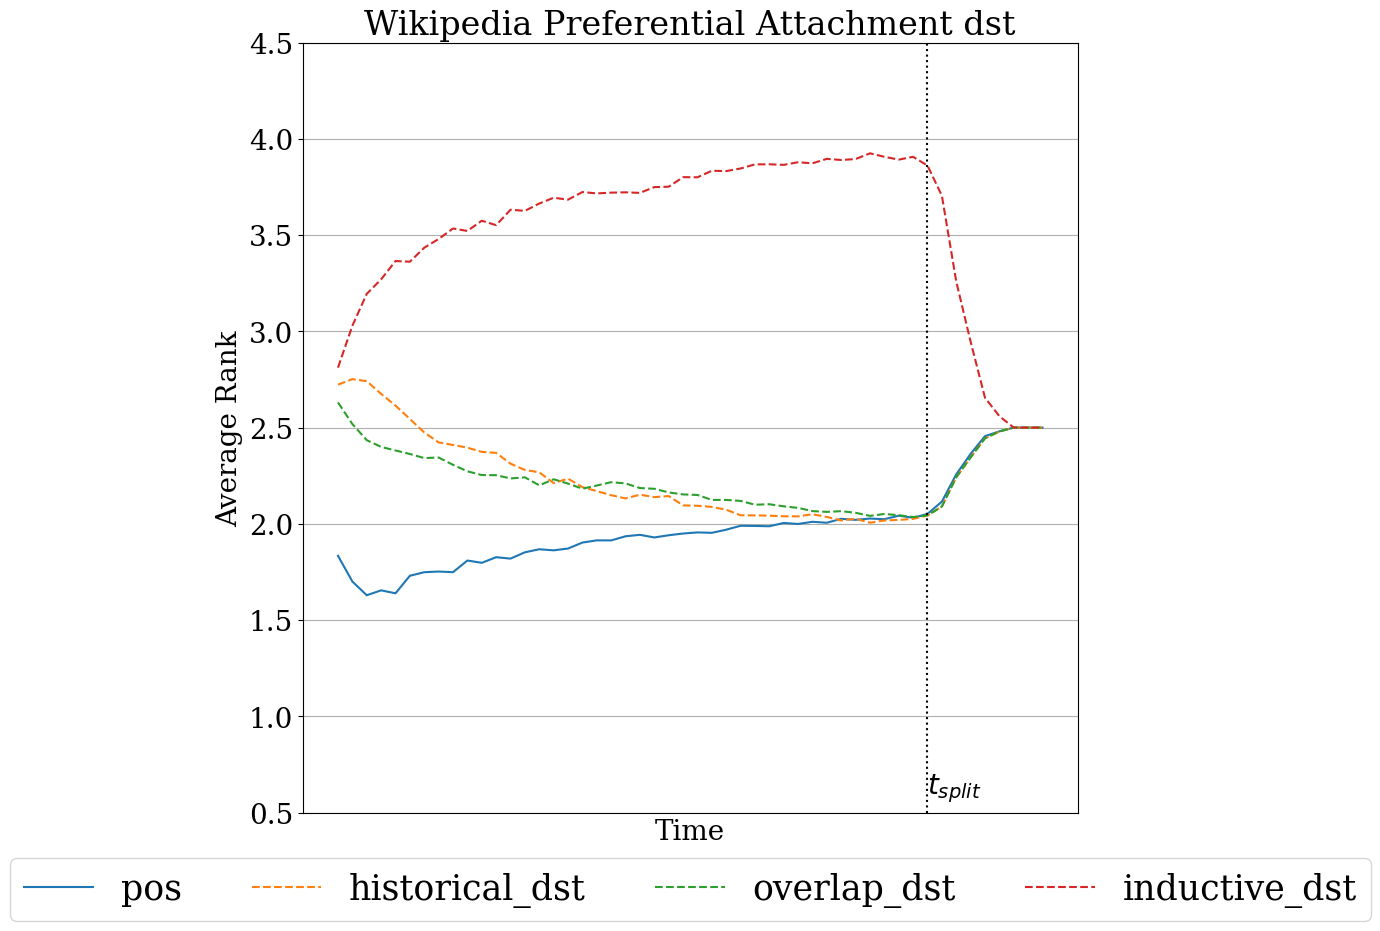

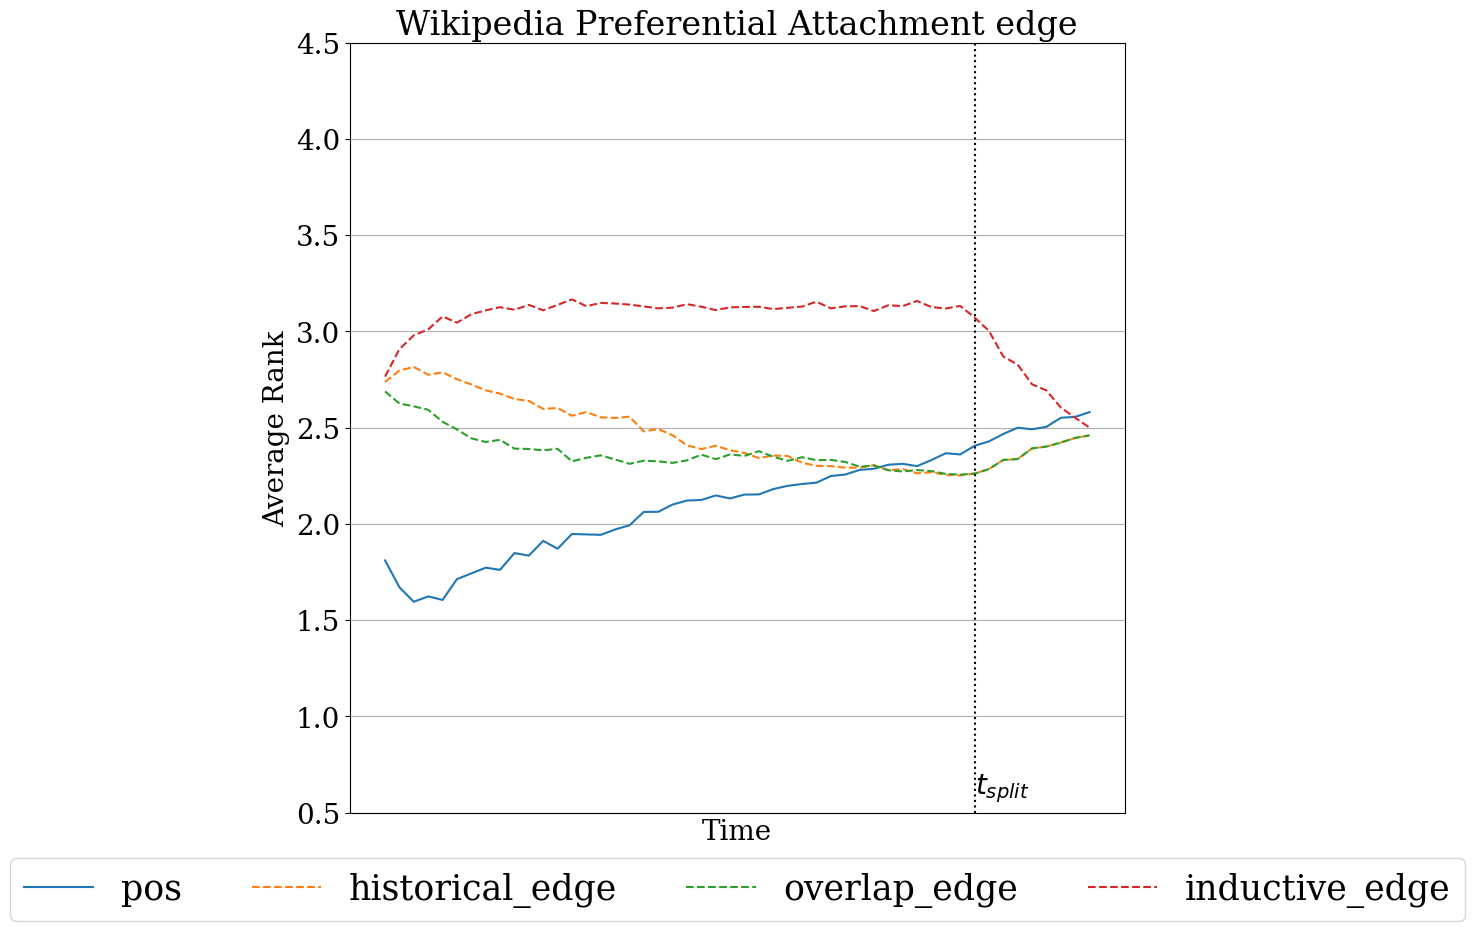

In [36]:
dataset, model = score_path.split("_")[:2]

scores_cols = [col for col in scores_df.columns if "score" in col]


def format_string(x):
    """
    Replace underscore by spaces
    Capitalize first letter of each word
    """
    return " ".join([s.capitalize() for s in x.split("_")])


for competitor_suffix in ["dst", "edge"]:

    fig, ax = plt.subplots(figsize=(10, 10), sharey=True, gridspec_kw={"wspace": 0.05})
    scores_df = pd.read_csv(score_path, index_col=0)
    _, _, test_mask = train_val_test_split_dataframe(
        scores_df, val_ratio=0.0, test_ratio=0.15
    )

    dataset, model = score_path.split("_")[:2]

    scores_cols = ["score_pos"] + [
        "score_" + t_ + competitor_suffix
        for t_ in ["historical_", "overlap_", "inductive_"]
    ]
    scores_cols = [col for col in scores_cols if col in scores_df.columns]

    ranks_df = scores_df[scores_cols].rank(axis=1, ascending=False)
    ranks_df["t"] = scores_df["t"]
    ranks_df["time_idx"] = pd.cut(ranks_df["t"], bins=50, labels=False)
    # test_time_idx = ranks_df[ranks_df["t"] > events.test_time]["time_idx"].min()
    test_time_idx = ranks_df[test_mask]["time_idx"].min()
    ranks_df = ranks_df.groupby("time_idx").mean()

    # def get_color(col):
    #     if "historical" in col:
    #         return "blue"
    #     if "overlap" in col:
    #         return "orange"
    #     if "inductive" in col:
    #         return "green"

    for col in scores_cols:
        ax.plot(
            ranks_df[col],
            label=col,
            linestyle="-" if "pos" in col else "--",
            # color=get_color(col),
        )

    # ranks_df[scores_cols].plot()
    ax.set_xlabel("Time")
    ax.set_ylabel("Average Rank")

    # ax.set_title(format_string(method))
    ax.set_xticks([])
    # ax.vlines(test_time_idx, ymin, ymax, linestyles="dashed", color="black")
    ax.axvline(
        test_time_idx,
        color="black",
        linestyle="dotted",
        # label="Test Cutoff Time",
    )

    handles, labels = ax.get_legend_handles_labels()
    # Remove legend
    leg = ax.get_legend()
    if leg:
        leg.remove()

    ymin = 0.5
    ymax = 4.5
    ax.set_ylim(ymin, ymax)

    if True:
        ax.annotate(
            r"$t_{split}$",
            xy=(test_time_idx, ymin),
            xytext=(test_time_idx, ymin + 0.1),
            # arrowprops=dict(facecolor="black", shrink=0.05),
        )
    ax.set_title(
        format_string(dataset_name)
        + " "
        + format_string(method)
        + " "
        + competitor_suffix
    )
    ax.set_xticks([])

    labels = [r.replace("score_", "") for r in labels]
    ax.legend(
        handles,
        labels,
        loc="center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=5,
    )